In [1]:
# 필요한 라이브러리 설치
!pip install ultralytics torchvision matplotlib opencv-python
!pip install transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 15.1 MB/s eta 0:00:00


In [2]:
# 필요한 라이브러리 임포트
import torch
from ultralytics import YOLO
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests
import cv2
import os
import matplotlib.pyplot as plt
import time

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# 1. Google Drive 연결
from google.colab import drive
drive.mount('/content/drive')

# 이미지 경로 설정
image_dir = "/content/drive/MyDrive/24-2/DeepLearning/FinalProject/Fog_test"
output_dir = "/content/drive/MyDrive/24-2/DeepLearning/FinalProject/Fog_test_result"    # 결과 저장 폴더
os.makedirs(output_dir, exist_ok=True)


Mounted at /content/drive


In [4]:
# 2. 모델 로드
# YOLOv8
yolo_model = YOLO("yolov8n.pt")

# Faster R-CNN
fasterrcnn_model = fasterrcnn_resnet50_fpn(pretrained=True).eval()

# DETR
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")


100%|██████████| 6.25M/6.25M [00:00<00:00, 17.9MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 113MB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: Us

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# COCO 클래스 이름 매핑
COCO_CLASSES = [
    "__background__", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
    "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie",
    "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon",
    "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "TV", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]


In [6]:
# 3. 이미지 로드 함수
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image.copy()  # Negative stride 문제 해결

In [7]:


# 4. YOLOv8 객체 탐지 함수
def detect_objects_yolo(model, image_path):
    results = model(image_path)
    detections = []
    for box, label, score in zip(results[0].boxes.xyxy, results[0].boxes.cls, results[0].boxes.conf):
        class_name = COCO_CLASSES[int(label)]  # 클래스 이름 매핑
        detections.append({
            "box": box.tolist(),
            "label": class_name,  # 클래스 이름 추가
            "score": score.item()
        })
    return detections


# 5. Faster R-CNN 객체 탐지 함수
def detect_objects_fasterrcnn(model, image_path):
    image = load_image(image_path)
    image_tensor = F.to_tensor(image).unsqueeze(0)
    outputs = model(image_tensor)
    detections = []

    for box, label, score in zip(outputs[0]["boxes"], outputs[0]["labels"], outputs[0]["scores"]):
        # 클래스 레이블 범위 확인 및 매핑
        if 0 <= int(label) < len(COCO_CLASSES):
            class_name = COCO_CLASSES[int(label)]
        else:
            class_name = "Unknown"  # 범위를 벗어난 경우 기본값

        detections.append({
            "box": box.tolist(),
            "label": class_name,
            "score": score.item()
        })
    return detections



# 6. DETR 객체 탐지 함수
def detect_objects_detr(model, processor, image_path):
    image = load_image(image_path)
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    detections = []
    for box, label, score in zip(outputs.pred_boxes[0], outputs.logits[0].argmax(-1), outputs.logits[0].softmax(-1).max(-1).values):
        cx, cy, w, h = box.tolist()
        x1 = cx - w / 2
        y1 = cy - h / 2
        x2 = cx + w / 2
        y2 = cy + h / 2

        # 클래스 레이블 범위 확인 및 매핑
        if 0 <= int(label) < len(COCO_CLASSES):
            class_name = COCO_CLASSES[int(label)]
        else:
            class_name = "Unknown"  # 범위를 벗어난 경우 기본값

        detections.append({
            "box": [x1, y1, x2, y2],
            "label": class_name,
            "score": score.item()
        })
    return detections


In [8]:
# 7. 바운딩 박스 시각화 함수
def visualize_predictions(image_path, detections, model_name):
    image = load_image(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for det in detections:
        x1, y1, x2, y2 = det["box"]
        label = det["label"]
        score = det["score"]

        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor="red", fill=False, linewidth=2))
        ax.text(x1, y1 - 10, f"{label} ({score:.2f})", color="red", fontsize=12, backgroundcolor="white")

    plt.title(f"{model_name} Predictions")
    plt.axis("off")
    plt.show()

# 8. 모델 비교 함수
def compare_models(image_dir):
    times = {"YOLOv8": [], "Faster R-CNN": [], "DETR": []}

    for image_file in os.listdir(image_dir):
        if image_file.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(image_dir, image_file)
            print(f"\nProcessing: {image_file}\n")

            # YOLOv8
            start_time = time.time()
            yolo_detections = detect_objects_yolo(yolo_model, image_path)
            yolo_time = time.time() - start_time
            times["YOLOv8"].append(yolo_time)
            visualize_predictions(image_path, yolo_detections, "YOLOv8")

            # Faster R-CNN
            start_time = time.time()
            fasterrcnn_detections = detect_objects_fasterrcnn(fasterrcnn_model, image_path)
            fasterrcnn_time = time.time() - start_time
            times["Faster R-CNN"].append(fasterrcnn_time)
            visualize_predictions(image_path, fasterrcnn_detections, "Faster R-CNN")

            # DETR
            start_time = time.time()
            detr_detections = detect_objects_detr(detr_model, processor, image_path)
            detr_time = time.time() - start_time
            times["DETR"].append(detr_time)
            visualize_predictions(image_path, detr_detections, "DETR")

    return times

# 9. 모델 비교 실행
times = compare_models(image_dir)

Output hidden; open in https://colab.research.google.com to view.

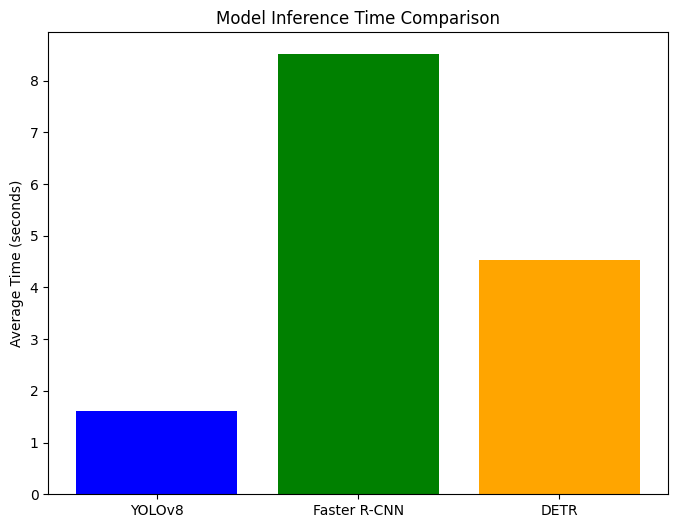

In [9]:
# 10. 결과 시각화: 속도 비교
average_times = {model: sum(times[model]) / len(times[model]) for model in times}

plt.figure(figsize=(8, 6))
plt.bar(average_times.keys(), average_times.values(), color=["blue", "green", "orange"])
plt.title("Model Inference Time Comparison")
plt.ylabel("Average Time (seconds)")
plt.show()